In [ ]:
import boto3
import botocore
import json
import s3fs
import ast
import pandas as pd
from pandas.io.json import json_normalize
from sagemaker import get_execution_role
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

In [2]:
role = 'AWSGlueServiceSageMakerNotebookRole-Default'

In [ ]:

bucket= 'sagemaker-studio-882308570215-o5kyfobq7l'

key = 'data/australian_user_reviews (2).json'

s3 = boto3.resource('s3')
try:
     s3.Bucket(bucket).download_file(key,'user_reviews.json')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [ ]:
BUCKET_NAME = 'sagemaker-studio-882308570215-o5kyfobq7l'

KEY = 'data/steam_games (3).json' 

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'steam_games (3).json')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

## Games Users Have Played

In [2]:
with open('users_items.json') as f:
    lines = f.read().splitlines()

In [3]:
lst = [ast.literal_eval(line) for line in lines]

In [4]:
users_items = pd.DataFrame(lst)

In [5]:
users_items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [6]:
users_items.shape

(88310, 5)

In [7]:
users_items.user_id.nunique()

87626

#### Drop Duplicates

In [8]:
users_items.drop_duplicates(subset ="user_id", 
                     keep = 'first', inplace = True) 

In [9]:
users_items.user_id.nunique()

87626

In [10]:
users_items.reset_index(inplace = True)

In [11]:
users_items.rename(columns={'index':'id'}, inplace = True)

In [12]:
users_items.head()

,id,user_id,items_count,steam_id,user_url,items
0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [13]:
users_items_lst = users_items.to_dict('records')

In [14]:
item_ratings = pd.json_normalize(data= users_items_lst, record_path = 'items', meta = ['user_id'])

In [15]:
item_ratings.head()

,item_id,item_name,playtime_forever,playtime_2weeks,user_id
0,10,Counter-Strike,6,0,76561197970982479
1,20,Team Fortress Classic,0,0,76561197970982479
2,30,Day of Defeat,7,0,76561197970982479
3,40,Deathmatch Classic,0,0,76561197970982479
4,50,Half-Life: Opposing Force,0,0,76561197970982479


In [16]:
item_ratings.user_id.nunique()

70912

In [17]:
user_id = item_ratings.user_id.unique()

In [18]:
index = list(range(len(user_id)))

In [19]:
id_col = dict(zip(user_id,index))

In [20]:
item_ratings['id'] = item_ratings.user_id.apply(lambda x : id_col[x])

In [ ]:
item_ratings.head()

In [22]:
item_ratings.shape

(5094082, 6)

In [23]:
item_ratings.user_id.nunique()

70912

In [24]:
item_ratings.item_id.nunique()

10978

In [25]:
item_ratings.dtypes

item_id             object
item_name           object
playtime_forever     int64
playtime_2weeks      int64
user_id             object
id                   int64
dtype: object

In [26]:
item_ratings.item_id = item_ratings.item_id.astype('int64')

In [27]:
item_ids = item_ratings.item_id.unique()

#### Item Names

In [28]:
item_id = item_ratings.item_id.unique()

In [29]:
item_name = item_ratings.item_name.unique()

In [30]:
names = dict(zip(item_id,item_name))

#### EDA

In [31]:
ratings_mat = item_ratings.pivot_table(values = 'playtime_forever',index = 'user_id',columns = 'item_id')

In [32]:
ratings_mat.head()

item_id,10,20,30,40,50,60,70,80,100,130,...,527520,527570,527810,527890,527900,528580,528660,529670,529820,530720
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2SV-vuLB-Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Density

In [33]:
num_ratings = item_ratings.shape[0]
user_count, item_count = ratings_mat.shape
density = num_ratings/(user_count*item_count)
print(density)

0.0065436938243076245


In [34]:
ratings_per_game = item_ratings.groupby('item_id')['playtime_forever'].count()
ratings_per_user = item_ratings.groupby('user_id')['playtime_forever'].count()

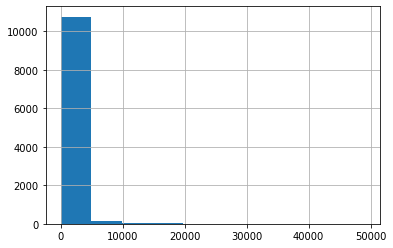

In [35]:
ratings_per_game.hist(bins = 10)

In [36]:
ratings_per_game.min()

1

In [37]:
ratings_per_game.max()

49136

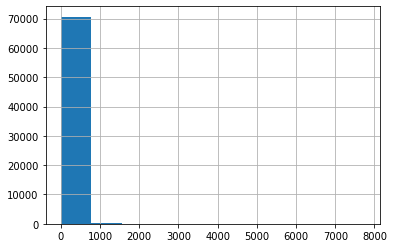

In [38]:
ratings_per_user.hist(bins = 10)

In [39]:
ratings_per_user.min()

1

In [40]:
ratings_per_user.max()

7762

#### Test with users who played 10 or more games

In [41]:
test= pd.DataFrame(ratings_per_user)

In [42]:
test.shape

(70912, 1)

In [43]:
test = test[test.playtime_forever>=10]

In [44]:
test.shape

(57333, 1)

In [45]:
test2 = pd.DataFrame(ratings_per_game)

In [46]:
test2.shape

(10978, 1)

In [47]:
test2.head()

,playtime_forever
item_id,
10,9611
20,6268
30,3431
40,3242
50,6216


In [48]:
test2=test2[test2.playtime_forever>=5000]

In [49]:
test2.shape

(210, 1)

In [50]:
item_ratings_test = item_ratings.loc[item_ratings.user_id.isin(test.index)]

In [51]:
item_ratings_test.shape

(5038365, 6)

In [52]:
item_ratings_test.user_id.nunique()

57333

In [53]:
item_ratings_test = item_ratings.loc[item_ratings.item_id.isin(test2.index)]

In [54]:
item_ratings_test.shape

(2175538, 6)

In [55]:
test_ratings_mat = item_ratings_test.pivot_table(values = 'playtime_forever',index = 'user_id',columns = 'item_id')

In [56]:
num_ratings = item_ratings_test.shape[0]
user_count, item_count = test_ratings_mat.shape
density = num_ratings/(user_count*item_count)
print(density)

0.14729926720656272


In [57]:
test_ratings_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,606.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2SV-vuLB-Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3963.0,NaN,...,0.0,NaN,NaN,NaN,7189.0,0.0,0.0,0.0,NaN,NaN


In [58]:
test_ratings_mat.shape

(70331, 210)

In [59]:
test_sim_mat = cosine_similarity(test_ratings_mat.fillna(0).T)

In [60]:
test_sim_mat = pd.DataFrame(test_sim_mat, index =test_ratings_mat.columns)

In [61]:
test_sim_mat.columns = test_ratings_mat.columns


In [62]:
test_sim_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
item_id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.092259,0.069320,0.080584,0.099396,0.124088,0.082316,0.030718,0.088200,0.003783,...,0.014453,0.004881,0.000051,0.006318,0.001455,0.001391,0.000900,0.002059,0.011238,0.000798
20,0.092259,1.000000,0.297279,0.278031,0.001416,0.012805,0.358151,0.017713,0.029620,0.002242,...,0.035066,0.001105,0.000105,0.004569,0.000184,0.000123,0.000704,0.000334,0.000129,0.000170
50,0.069320,0.297279,1.000000,0.652573,0.004850,0.037226,0.786129,0.134048,0.009768,0.011436,...,0.016225,0.006167,0.001377,0.020579,0.001177,0.001885,0.004562,0.001688,0.000276,0.000212
70,0.080584,0.278031,0.652573,1.000000,0.014225,0.064119,0.730124,0.191296,0.034675,0.010190,...,0.053881,0.014455,0.006002,0.039472,0.004037,0.004576,0.012608,0.002213,0.001969,0.000652
80,0.099396,0.001416,0.004850,0.014225,1.000000,0.134090,0.002032,0.012981,0.051029,0.004860,...,0.004199,0.000948,0.000232,0.003840,0.000387,0.000523,0.000253,0.000075,0.001599,0.000023


In [63]:
test_sim_mat.shape

(210, 210)

In [64]:
def predict(user_id,sim_mat, ratings_mat, neighbors):
    
    sorted_sim_idx = np.argsort(np.array(test_sim_mat))
    nbh = sorted_sim_idx[:, -neighbors:]
    items_rated = np.array(ratings_mat.iloc[user_id].fillna(0)).nonzero()
    pred = np.zeros(test_sim_mat.shape[0])                                                         
    
    for item_to_rate in range(sim_mat.shape[0]):
        
        relevant_items = np.intersect1d(nbh[item_to_rate], items_rated, assume_unique =True)
        pred[item_to_rate] = ((sim_mat.iloc[item_to_rate,relevant_items].values*\
                               ratings_mat.iloc[user_id,relevant_items].values).sum())\
                                /(sim_mat.iloc[item_to_rate,relevant_items].sum())
    
    preds= np.nan_to_num(pred)
    return preds                                                         
                                                              

In [65]:
user_0 = predict(0, test_sim_mat, test_ratings_mat,20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [66]:
user_0.argsort()[::-1][:10]

array([ 36, 149,  35, 140,   1, 134, 208,  18,   0, 176])

In [67]:
test_sim_mat.shape

(210, 210)

#### Train Test Split

In [145]:
train_ratings_mat = test_ratings_mat.copy()

In [146]:
train_ratings_mat.shape

(70331, 210)

#### Filtered Out Users Who Have Played 25 or more Games

In [147]:
train_ratings_mat = train_ratings_mat[(train_ratings_mat.fillna(0) !=0).sum(axis = 1)>=25]

In [148]:
train_ratings_mat.shape

(25723, 210)

In [71]:
## filter rated games
ratings = np.array(train_ratings_mat.iloc[0].fillna(0)).nonzero()[0]
ratings

array([ 16,  18,  19,  23,  34,  51,  78,  90,  91,  98,  99, 111, 121,
       131, 143, 153, 155, 163, 164, 179, 189, 190, 191, 197, 201])

In [72]:
# hold random 5 for testing
idx = np.random.choice(ratings, size = 5 )

In [73]:
idx

array([ 78,  90, 131, 155, 191])

In [74]:
train_ratings_mat.iloc[0,idx]

item_id
55230     1922.0
104900      63.0
218620     416.0
230410     107.0
304930    4037.0
Name: --000--, dtype: float64

In [138]:
train_ratings_mat.shape

(31939, 210)

In [76]:
train_ratings_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,606.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3963.0,NaN,...,0.0,NaN,NaN,NaN,7189.0,0.0,0.0,0.0,NaN,NaN
-AnimeIsMyThing-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6119.0,NaN,...,NaN,4151.0,0.0,NaN,21446.0,0.0,NaN,NaN,2237.0,0.0


In [149]:
train_sim_mat = cosine_similarity(train_ratings_mat.fillna(0).T)

In [150]:
train_sim_mat = pd.DataFrame(train_sim_mat, index =train_ratings_mat.columns)
train_sim_mat.columns = train_ratings_mat.columns

In [151]:
test_set = []
for i in range(train_ratings_mat.shape[0]):
    ratings = np.array(train_ratings_mat.iloc[i].fillna(0)).nonzero()[0]
    idx = np.random.choice(ratings,size =  5, replace = False)
    #append values to test_set
    test_set.append(idx)
    # change value to nan 
    train_ratings_mat.iloc[i,idx]=np.nan
    
    
    

#### Evaluation

In [81]:
pred_ratings = [predict(user_id, train_sim_mat, train_ratings_mat,10) for user_id in range(10)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [83]:
pred_ratings

[array([1.07119000e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.07119000e+05, 5.26641437e+04, 0.00000000e+00, 9.25000000e+02,
        6.52367812e+04, 0.00000000e+00, 9.25000000e+02, 0.00000000e+00,
        9.25000000e+02, 0.00000000e+00, 9.25000000e+02, 2.94900000e+03,
        9.25000000e+02, 1.04815642e+03, 6.69798553e+04, 2.94900000e+03,
        1.27952495e+03, 1.34935173e+03, 9.25000000e+02, 1.52732998e+04,
        6.30000000e+01, 1.07119000e+05, 8.78326808e+02, 0.00000000e+00,
        1.92200000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.92200000e+03, 6.30000000e+01, 4.67376394e+02, 0.00000000e+00,
        1.07119000e+05, 1.92200000e+03, 1.92200000e+03, 1.92200000e+03,
        0.00000000e+00, 0.00000000e+00, 2.93965124e+04, 1.92200000e+03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.92200000e+03, 2.40686656e+03,
        1.92200000e+03, 1.04152915e+03, 0.00000000e+00, 0.000000

In [91]:
first_pred = pred_ratings[0].argsort()[::-1][:5]

In [92]:
first_test = test_set[0]

In [95]:
len(np.intersect1d(first_pred,first_test))

0

In [100]:
hits = 0
for i, pred in enumerate(pred_ratings):
    top_5 = pred.argsort()[::-1][:5]
    test = test_set[i]
    hits += len(np.intersect1d(top_5,test))
    

In [111]:
hits/50

0.02

In [152]:
train_ratings = [predict(user_id, train_sim_mat, train_ratings_mat,10) for user_id in range(train_ratings_mat.shape[0])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [154]:
len(train_ratings)

25723

In [155]:
hits = 0
for i, pred in enumerate(train_ratings):
    top_5 = pred.argsort()[::-1][:5]
    test = test_set[i]
    hits += len(np.intersect1d(top_5,test))
    

In [157]:
hits/(len(test_set)*5)

0.021163938887377054

#### See How the Recommendations Compare to the Games User_0 Actually played

Recommendations

In [240]:
user_0_idx= train_ratings[0].argsort()[::-1][:5]

In [241]:
user_0_game_recommendations = train_ratings_mat.iloc[0,user_0_idx].index

In [243]:
user_0_game_recommendations 

Int64Index([10190, 221380, 202990, 42710, 346110], dtype='int64', name='item_id')

In [267]:
user_0_game_recs = [names[i]for i in user_0_game_recommendations]
for i in range(len(user_0_game_recs)):
    print(user_0_game_recs[i])

Dragon Age: Origins
Spintires
Infestation: Survivor Stories Classic
Flight Control HD
Penumbra: Necrologue


In [262]:
games[games.id.isin(user_0_game_recommendations)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
11216,Studio Wildcard,"[Action, Adventure, Indie, Massively Multiplay...",ARK: Survival Evolved,ARK: Survival Evolved,http://store.steampowered.com/app/346110/ARK_S...,2017-08-29,"[Survival, Dinosaurs, Open World, Multiplayer,...",NaN,http://steamcommunity.com/app/346110/reviews/?...,"[Single-player, Multi-player, MMO, Co-op, Stea...",59.99,False,346110,"Studio Wildcard,Instinct Games,Efecto Studios,...",Mixed,70
30246,Microsoft Studios,[Strategy],Age of Empires II HD,Age of Empires II HD,http://store.steampowered.com/app/221380/Age_o...,2013-04-09,"[Strategy, RTS, Medieval, Multiplayer, Classic...",NaN,http://steamcommunity.com/app/221380/reviews/?...,"[Single-player, Multi-player, Steam Achievemen...",19.99,False,221380,"Skybox Labs,Hidden Path Entertainment,Ensemble...",Very Positive,68


In [268]:
games[games.title.isin(user_0_game_recs)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
342,Electronic Arts,[RPG],Dragon Age: Origins,Dragon Age: Origins,http://store.steampowered.com/app/17450/Dragon...,2009-11-06,"[RPG, Fantasy, Story Rich, Multiple Endings, S...",NaN,http://steamcommunity.com/app/17450/reviews/?b...,[Single-player],19.99,False,17450,BioWare,Very Positive,91
535,Firemint,"[Action, Casual]",Flight Control HD,Flight Control HD,http://store.steampowered.com/app/62000/Flight...,2010-11-18,"[Casual, Action, Arcade, Touch-Friendly, Singl...",NaN,http://steamcommunity.com/app/62000/reviews/?b...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,62000,Firemint,Very Positive,NaN
27434,CounterCurrent Games,"[Action, Adventure, Indie]",Penumbra: Necrologue,Penumbra: Necrologue,http://store.steampowered.com/app/346290/Penum...,2015-02-06,"[Horror, Adventure, Indie, Action, Mod, Free t...",NaN,http://steamcommunity.com/app/346290/reviews/?...,"[Single-player, Full controller support, Capti...",NaN,False,346290,CounterCurrent Games,Very Positive,NaN


Games user_0 actually played

In [276]:
user_0_games_played = np.array(train_ratings_mat.iloc[0].fillna(0)).nonzero()

In [277]:
user_0_games_played[]

(array([ 16,  18,  19,  23,  34,  78,  91,  98,  99, 131, 143, 153, 155,
        163, 164, 179, 190, 191, 197, 201]),)

In [284]:
user_0_games_played = train_ratings_mat.iloc[0,user_0_games_played[0]].index

In [286]:
user_0_games_played = [names[i] for i in user_0_games_played]
for game in user_0_games_played:
    print(game)

Left 4 Dead 2 Beta
Borderlands 2
Killing Floor Mod: Defence Alliance 2
Just Cause
Warhammer® 40,000™: Dawn of War® II
Costume Quest
Frozen Synapse
No More Room in Hell
MapleStory
Saints Row IV
Creeper World 3: Arc Eternal
Roommates
Edge of Space
Transistor
Beatbuddy: Tale of the Guardians
Kerbal Space Program
Dragon Saga
METAL GEAR SOLID V: GROUND ZEROES
Armikrog
Spore: Creepy & Cute Parts Pack


In [287]:
games[games.title.isin(user_0_games_played)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
639,Mode 7,"[Indie, Strategy]",Frozen Synapse,Frozen Synapse,http://store.steampowered.com/app/98200/Frozen...,2011-05-26,"[Strategy, Turn-Based, Tactical, Indie, Asynch...",NaN,http://steamcommunity.com/app/98200/reviews/?b...,"[Single-player, Multi-player, Steam Achievemen...",24.99,False,98200,Mode 7,Very Positive,85
756,Double Fine Productions,"[Adventure, Casual, RPG]",Costume Quest,Costume Quest,http://store.steampowered.com/app/115100/Costu...,2011-10-14,"[RPG, Adventure, Comedy, Casual, Singleplayer,...",NaN,http://steamcommunity.com/app/115100/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",9.99,False,115100,Double Fine Productions,Overwhelmingly Positive,NaN
1516,Threaks,"[Action, Adventure, Casual, Indie]",Beatbuddy: Tale of the Guardians,Beatbuddy: Tale of the Guardians,http://store.steampowered.com/app/231040/Beatb...,2013-08-06,"[Indie, Music, Adventure, Rhythm, Casual, Acti...",NaN,http://steamcommunity.com/app/231040/reviews/?...,"[Single-player, Steam Achievements, Full contr...",9.99,False,231040,Threaks,Very Positive,75
2982,Konami Digital Entertainment,"[Action, Adventure]",METAL GEAR SOLID V: GROUND ZEROES,METAL GEAR SOLID V: GROUND ZEROES,http://store.steampowered.com/app/311340/METAL...,2014-12-18,"[Stealth, Action, Short, Tactical, Singleplaye...",NaN,http://steamcommunity.com/app/311340/reviews/?...,"[Single-player, Steam Achievements, Full contr...",19.99,False,311340,Kojima Productions,Very Positive,80
4403,Reverb Triple XP,"[Action, Adventure, Indie, RPG]",Edge of Space,Edge of Space,http://store.steampowered.com/app/238240/Edge_...,2015-09-17,"[Sandbox, Indie, Adventure, Action, 2D, Crafti...",NaN,http://steamcommunity.com/app/238240/reviews/?...,"[Single-player, Multi-player, Co-op, Steam Ach...",14.99,False,238240,Handyman Studios,Mixed,NaN
4475,Versus Evil,"[Adventure, Indie]",Armikrog,Armikrog,http://store.steampowered.com/app/334120/Armik...,2015-09-30,"[Adventure, Indie, Point & Click, Comedy, Puzz...",NaN,http://steamcommunity.com/app/334120/reviews/?...,[Single-player],9.99,False,334120,Pencil Test Studios,Mixed,57
24516,Gravity Interactive,"[Free to Play, Massively Multiplayer]",Dragon Saga,Dragon Saga,http://store.steampowered.com/app/381990/Drago...,2010-10-28,"[Free to Play, Massively Multiplayer, MMORPG, ...",NaN,http://steamcommunity.com/app/381990/reviews/?...,"[Single-player, Multi-player, MMO, Steam Achie...",Free to Play,False,381990,Gravity Interactive,Mostly Positive,65
26896,Private Division,"[Indie, Simulation]",Kerbal Space Program,Kerbal Space Program,http://store.steampowered.com/app/220200/Kerba...,2015-04-27,"[Space, Simulation, Sandbox, Physics, Science,...",NaN,http://steamcommunity.com/app/220200/reviews/?...,"[Single-player, Steam Trading Cards]",39.99,False,220200,Squad,Overwhelmingly Positive,88
29002,Supergiant Games,"[Action, Indie, RPG]",Transistor,Transistor,http://store.steampowered.com/app/237930/Trans...,2014-05-20,"[Great Soundtrack, Female Protagonist, Indie, ...",NaN,http://steamcommunity.com/app/237930/reviews/?...,"[Single-player, Steam Achievements, Full contr...",19.99,False,237930,Supergiant Games,Overwhelmingly Positive,83
29278,Knuckle Cracker,"[Indie, Simulation, Strategy]",Creeper World 3: Arc Eternal,Creeper World 3: Arc Eternal,http://store.steampowered.com/app/280220/Creep...,2014-03-27,"[Strategy, Tower Defense, Indie, Sci-fi, RTS, ...",NaN,http://steamcommunity.com/app/280220/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",14.99,False,280220,Knuckle Cracker,Overwhelmingly Positive,NaN


#### Binary Train Set

In [200]:
binary_ratings_mat = train_ratings_mat.copy()

In [201]:
binary_ratings_mat.fillna(0, inplace = True)

In [202]:
binary_ratings_mat[binary_ratings_mat!= 0]=1

In [203]:
binary_train.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-404PageNotFound-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
-AnimeIsMyThing-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
-Azsael-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
-GM-Dragon,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [205]:
binary_ratings_mat.shape

(25723, 210)

In [206]:
binary_sim_mat = cosine_similarity(binary_ratings_mat.T)

In [207]:
binary_sim_mat

array([[1.        , 0.28087585, 0.24429448, ..., 0.02483223, 0.11692905,
        0.02535518],
       [0.28087585, 1.        , 0.46726923, ..., 0.03626067, 0.05120387,
        0.01250171],
       [0.24429448, 0.46726923, 1.        , ..., 0.03808209, 0.02860738,
        0.00706983],
       ...,
       [0.02483223, 0.03626067, 0.03808209, ..., 1.        , 0.01721829,
        0.        ],
       [0.11692905, 0.05120387, 0.02860738, ..., 0.01721829, 1.        ,
        0.16968228],
       [0.02535518, 0.01250171, 0.00706983, ..., 0.        , 0.16968228,
        1.        ]])

In [208]:
binary_sim_mat = pd.DataFrame(binary_sim_mat, index =binary_ratings_mat.columns)
binary_sim_mat.columns = binary_ratings_mat.columns

In [288]:
binary_sim_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
item_id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.280876,0.244294,0.319064,0.624034,0.476740,0.237224,0.319999,0.391497,0.271649,...,0.151981,0.152361,0.043638,0.171947,0.118159,0.062672,0.060451,0.024832,0.116929,0.025355
20,0.280876,1.000000,0.467269,0.503379,0.249255,0.208363,0.462701,0.325663,0.256313,0.340841,...,0.117658,0.104715,0.045907,0.137093,0.082407,0.035216,0.058370,0.036261,0.051204,0.012502
50,0.244294,0.467269,1.000000,0.472693,0.240980,0.229228,0.685734,0.316457,0.232749,0.334738,...,0.086222,0.083506,0.046153,0.140928,0.061125,0.027708,0.073041,0.038082,0.028607,0.007070
70,0.319064,0.503379,0.472693,1.000000,0.260498,0.220725,0.464866,0.455967,0.354746,0.385184,...,0.150102,0.148132,0.068003,0.236434,0.117636,0.044653,0.108656,0.044961,0.069395,0.015191
80,0.624034,0.249255,0.240980,0.260498,1.000000,0.550113,0.224939,0.263255,0.319610,0.243182,...,0.126513,0.132583,0.034555,0.124415,0.095091,0.053966,0.045477,0.023711,0.090927,0.017167


In [219]:
def train_test(ratings_mat):
    train = ratings_mat.copy()
    test = []
    for i in range(train.shape[0]):
        ratings = np.array(train.iloc[i].fillna(0)).nonzero()[0]
        idx = np.random.choice(ratings,size =  5, replace = False)
        #append values to test_set
        test.append(idx)
        # change value to nan 
        train.iloc[i,idx]=np.nan
    return train, test

In [ ]:
binary_predictions=[predict(user_id, binary_sim_mat, binary_ratings_mat,10) for user_id in range(binary_ratings_mat.shape[0])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


## User Reviews

In [57]:
with open('user_reviews.json') as f:
    lines2 = f.read().splitlines()

In [72]:
lst2 = [ast.literal_eval(line) for line in lines2]

In [73]:
user_reviews = pd.DataFrame(lst2)

In [74]:
user_reviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [75]:
user_reviews.shape

(25799, 3)

In [76]:
user_reviews.user_id.nunique()

25485

In [77]:
user_reviews.drop_duplicates(subset ="user_id", 
                     keep = 'first', inplace = True) 

In [78]:
user_reviews.user_id.nunique()

25485

In [79]:
user_reviews_lst = user_reviews.to_dict('records')

In [80]:
reviews = pd.json_normalize(data= user_reviews_lst, record_path = 'reviews', meta = ['user_id'])

In [81]:
reviews.head()

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637


In [82]:
reviews.user_id.nunique()

25457

In [83]:
reviews.item_id.nunique()

3682

## Games

In [248]:
with open('steam_games (3).json') as f:
    lines3 = f.read().splitlines()

In [249]:
lst = [ast.literal_eval(line) for line in lines3]

In [250]:
games = pd.DataFrame(lst)

In [251]:
games = pd.DataFrame(lst)

In [252]:
games.shape

(32135, 16)

In [253]:
games.isnull().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [254]:
games.id.nunique()

32132

In [255]:
games.sentiment.nunique()

18

In [256]:
games.sentiment.unique()

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [257]:
games.sentiment.value_counts()

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64

In [258]:
games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [259]:
games.dropna(axis=0, subset=['id'], inplace = True)

In [260]:
games.isnull().sum()

publisher          8051
genres             3282
app_name              1
title              2049
url                   0
release_date       2066
tags                162
discount_price    31909
reviews_url           0
specs               669
price              1377
early_access          0
id                    0
developer          3298
sentiment          7181
metascore         29457
dtype: int64

In [261]:
games.id = games.id.astype('int64')

#### Game Info for games in user_items

In [ ]:
len(item_ids)

In [ ]:
games_id = games.id.unique()

In [ ]:
intersect = np.intersect1d(item_ids, games_id)

In [ ]:
len(intersect)

In [ ]:
game_info = games.loc[games.id.isin(intersect)]

In [ ]:
game_info.head()

In [ ]:
game_info.isnull().sum()

In [ ]:
game_info.sentiment.value_counts()